# Inversion of Seismic Refraction Data

In this notebook you will use a forward model for refraction of seismic waves in a layered half space to invert seismic refraction data. The first part of the notebook will walk you through inversion of a synthetic dataset, then in the second part you will set up an inversion of a real dataset from the forelands of [Sit' Tlein (Malaspina Glacier)](https://esrs.jsc.nasa.gov/Collections/EarthFromSpace/lores.pl?PHOTO=STS028-97-81) in southern Alaska.  

# Part 0 - Information about the model

In seismic refraction studies, scientists use forward modeling and inversion techniques to understand the subsurface structure based on seismic wave travel times. 

## About forward modeling: 
Forward modeling is a crucial step in analyzing seismic refraction data. It involves creating a synthetic model of the subsurface and predicting how seismic waves would behave in that model. Scientists typically start with a simplified representation of the Earth called a layered half-space model. This model consists of:
* Multiple horizontal layers with different seismic velocities 
* An underlying half-space (a layer extending infinitely downward)

Each layer is characterized by its thickness and seismic velocity. The key assumption is that seismic velocity increases with depth, which is often true in real geological settings. 

## About ray tracing: 
In the forward model, scientists use ray tracing to calculate the paths of seismic waves through the layered model. Ray tracing involves:
* Calculating the paths of direct waves, refracted waves, and reflected waves
* Determining the travel times for each wave type 
* Identifying which waves arrive first at different distances from the source 

For a simple two-layer model, this process typically involves calculating the critical angle using Snell's Law, determining the crossover distance, followed by computing travel times for direct and refracted waves at various distances. 

# Part 1 - Synthetic example

To begin we will generate a synthetic dataset with a forward model, add some noise, and then try to invert to recover the starting earth model. You won't need to do any programming in this part - the goal is just to familiarize you with the tools in this notebook so that you can use them to invert the real dataset later on.

In [1]:
import sys
import os

os.chdir("/Users/winniechu/Documents/Teaching/Geophysics/2024/lab/lab4-tdem-refraction")
sys.path.insert(0, os.getcwd())

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import matplotlib
import refract

## Generate synthetic data

First we will set up a fake seismic refraction survey, and then generate synthetic data with it.

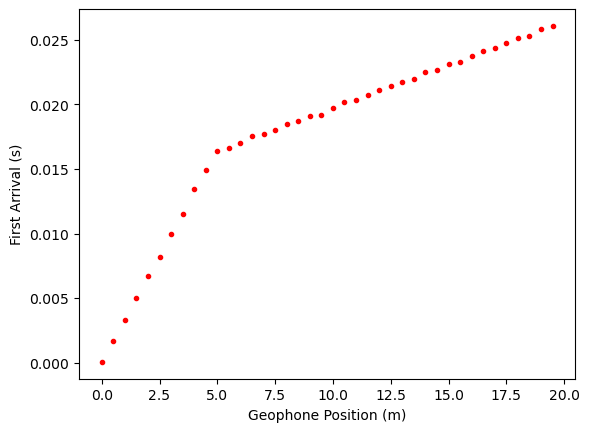

In [3]:
geox = np.arange(0, 20, 0.5)  # geophone locations (m along geophone line)
shotx = np.zeros_like(geox)  # shot location (m along geophone line
h = [2]
v = [300, 1500]

tt_synth = refract.refract4wardmodel(h, v, shotx, geox)
tt_synth += np.random.normal(loc=0, scale=1e-4, size=len(tt_synth))

plt.plot(geox, tt_synth, "r.")
plt.xlabel("Geophone Position (m)")
plt.ylabel("First Arrival (s)")
plt.show()

## Invert synthetic data

First we need to define what a good fit to the synthetic data is. We will choose the L2 norm, $||data-model||^2_2$. The function `misfit_3lyr` implements this. We will need to pick a starting set of parameters for the inversion, `x0`. This is a very important input - just as important as the choice of misfit function. Choosing a bad initial `x0` can make it impossible for your optimizer to find a good-fitting solution. For this synthetic example we know the correct solution, but with real data you never do and must often use other knowledge to come up with a good `x0` I'll choose something that generally represents the electro-stratigraphy (resistive, conductive, resistive) but is notable different from what we know to be the true model.

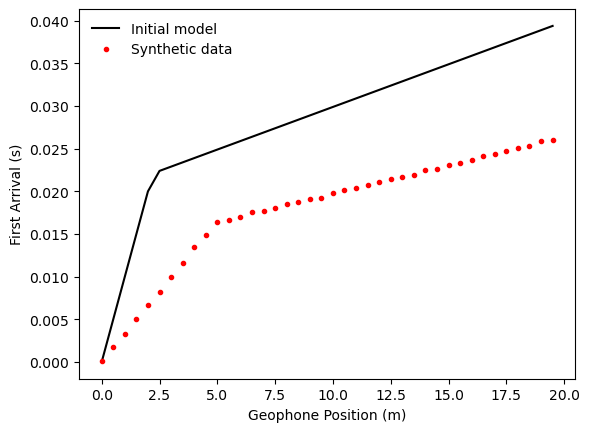

In [4]:
def misfit_nlyr(x, tt_obs, shotx, geox):
    # Split x into velocity and thickness
    nlyr = (len(x) + 1) // 2
    layer_velocities = x[:nlyr]
    layer_thicknesses = x[nlyr:]
    tt_model = refract.refract4wardmodel(
        layer_thicknesses, layer_velocities, shotx, geox
    )

    return np.sum(np.power(tt_obs - tt_model, 2))


init_layer_velocities = [100, 1000]
init_layer_thicknesses = [1]

x0 = init_layer_velocities + init_layer_thicknesses

# We also need to provide parameter bounds for the inversion, here I am constraining the velocities to between 50 and 5000 m/s
# and the layer thickness to between 0.5 and 10 meters
bounds = [(50, 5000)] * 2 + [(0.5, 10)] * 1

# Forward model
tt_x0 = refract.refract4wardmodel(
    init_layer_thicknesses, init_layer_velocities, shotx, geox
)

# Plot
plt.plot(geox, tt_x0, "k-", label="Initial model")
plt.plot(geox, tt_synth, "r.", label="Synthetic data")
plt.legend(frameon=False)
plt.xlabel("Geophone Position (m)")
plt.ylabel("First Arrival (s)")
plt.show()

We start to replicate the shape of the observed decay curve, but are still quite different! Now we can run a minimization algorithm to seek an earth model that better matches the observed data. The function call below implements this. See this page for information about all of the arguments. Optimization (a.k.a. minimization) is a complex topic, worthy of class(es) in its own right. The next cell will take several tens of seconds to run.

In [5]:
# Run optimizer
res = scipy.optimize.minimize(
    misfit_nlyr,
    x0,
    method="nelder-mead",
    args=(tt_synth, shotx, geox),
    bounds=bounds,
    options={"xatol": 1e-10, "maxfev": len(x0) * 300},
)

print(res)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 2.656731563037998e-07
             x: [ 3.012e+02  1.497e+03  2.006e+00]
           nit: 231
          nfev: 444
 final_simplex: (array([[ 3.012e+02,  1.497e+03,  2.006e+00],
                       [ 3.012e+02,  1.497e+03,  2.006e+00],
                       [ 3.012e+02,  1.497e+03,  2.006e+00],
                       [ 3.012e+02,  1.497e+03,  2.006e+00]]), array([ 2.657e-07,  2.657e-07,  2.657e-07,  2.657e-07]))


You should see `message: Optimization terminated successfully.` if everything worked well so far. Let's plot the result.

Inverted layer velocities (m/s): [ 301.22202678 1497.26778904]
Inverted layer thicknesses (m): [2.0056663]


Text(0, 0.5, 'First Arrival (s)')

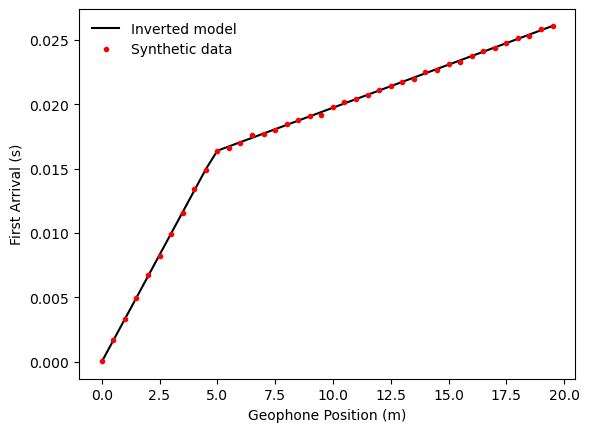

In [6]:
xinv = res.x
inv_layer_velocities = xinv[:2]
inv_layer_thicknesses = xinv[2:]
tt_inv = refract.refract4wardmodel(
    inv_layer_thicknesses, inv_layer_velocities, shotx, geox
)

print("Inverted layer velocities (m/s):", inv_layer_velocities)
print("Inverted layer thicknesses (m):", inv_layer_thicknesses)

# Plot
plt.plot(geox, tt_inv, "k-", label="Inverted model")
plt.plot(geox, tt_synth, "r.", label="Synthetic data")
plt.legend(frameon=False)
plt.xlabel("Geophone Position (m)")
plt.ylabel("First Arrival (s)")

Great! We've recovered our known original model. Now it is your turn.

# Part 2 - Real data

We provide you with a code snippet below that loads refraction data acquired in the forelands of Sit' Tlein. **Invert for a two-layer earth model and provide an estimate for the velocity structure of the forelands material Sit' Tlein.** Note - your answer should be reasonable but there is not an exact value we are seeking, as your result will vary based on your initial model and optimizer parameters.

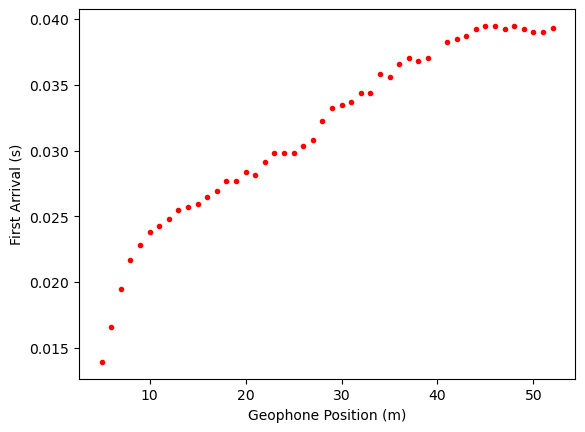

In [7]:
# Load refraction data
data = pd.read_csv(
    "/Users/winniechu/Documents/Teaching/Geophysics/2024/lab/lab4-tdem-refraction/geo4_refract.txt",
    delimiter=",",
    header=1,
)
tt_obs = data["tt"].to_numpy()
geox = data["geox"].to_numpy()
shotx = data["shotx"].to_numpy()

# Plot
plt.plot(geox, tt_obs, "r.")
plt.xlabel("Geophone Position (m)")
plt.ylabel("First Arrival (s)")
plt.show()

* Now, let's perform the inversion by building a forward model for seismic velocity, starting with some initial guess for the different layer thickness and velocities ( `init_layer_velocities` and  `init_layer_thicknesses`). 

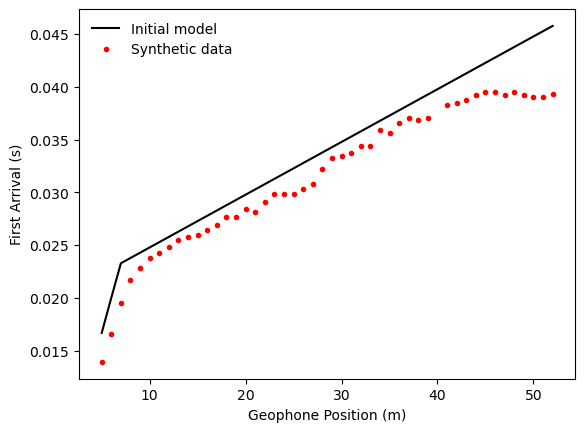

In [8]:
def misfit_nlyr(x, tt_obs, shotx, geox):
    # Split x into velocity and thickness
    nlyr = (len(x) + 1) // 2
    layer_velocities = x[:nlyr]
    layer_thicknesses = x[nlyr:]
    tt_model = refract.refract4wardmodel(
        layer_thicknesses, layer_velocities, shotx, geox
    )

    return np.sum(np.power(tt_obs - tt_model, 2))


init_layer_velocities = [300, 2000]
init_layer_thicknesses = [3]

x0 = init_layer_velocities + init_layer_thicknesses

# We also need to provide parameter bounds for the inversion, here I am constraining the velocities to between 50 and 5000 m/s
# and the layer thickness to between 0.5 and 10 meters
bounds = [(50, 5000)] * 2 + [(0.5, 10)] * 1

# Forward model
tt_x0 = refract.refract4wardmodel(
    init_layer_thicknesses, init_layer_velocities, shotx, geox
)

# Plot
plt.plot(geox, tt_x0, "k-", label="Initial model")
plt.plot(geox, tt_obs, "r.", label="Synthetic data")
plt.legend(frameon=False)
plt.xlabel("Geophone Position (m)")
plt.ylabel("First Arrival (s)")
plt.show()

In [9]:
# Run optimizer
result = scipy.optimize.minimize(
    misfit_nlyr,
    x0,
    method="nelder-mead",
    args=(tt_obs, shotx, geox),
    bounds=bounds,
    options={"xatol": 1e-10, "maxfev": len(x0) * 300},
)

print(result)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 3.802182004706807e-05
             x: [ 3.637e+02  2.401e+03  3.701e+00]
           nit: 166
          nfev: 337
 final_simplex: (array([[ 3.637e+02,  2.401e+03,  3.701e+00],
                       [ 3.637e+02,  2.401e+03,  3.701e+00],
                       [ 3.637e+02,  2.401e+03,  3.701e+00],
                       [ 3.637e+02,  2.401e+03,  3.701e+00]]), array([ 3.802e-05,  3.802e-05,  3.802e-05,  3.802e-05]))


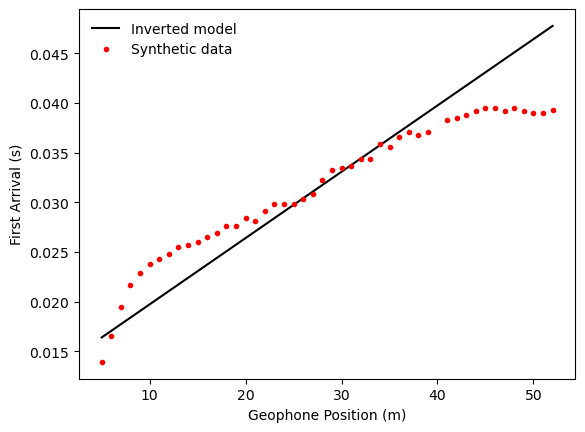

Seismic Model Inversion Results:
Layer 1: Velocity = 301 m/s, Thickness = 2.01 m


In [10]:
xinv = res.x
inv_layer_velocities = xinv[:2]
inv_layer_thicknesses = xinv[2:]
tt_inv = refract.refract4wardmodel(
    inv_layer_thicknesses, inv_layer_velocities, shotx, geox
)

# Plot
plt.plot(geox, tt_inv, "k-", label="Inverted model")
plt.plot(geox, tt_obs, "r.", label="Synthetic data")
plt.legend(frameon=False)
plt.xlabel("Geophone Position (m)")
plt.ylabel("First Arrival (s)")
plt.show()

print("Seismic Model Inversion Results:")
for i, (v, t) in enumerate(zip(inv_layer_velocities, inv_layer_thicknesses)):
    print(f"Layer {i+1}: Velocity = {v:.0f} m/s, Thickness = {t:.2f} m")

In [11]:
# Extract inverted velocities and thicknesses
inv_layer_velocities = xinv[:2]
inv_layer_thicknesses = xinv[2:]

# Calculate depths from thicknesses
inv_depths = np.cumsum(inv_layer_thicknesses)

# Calculate predicted travel times using the inverted parameters
tpred = refract.refract4wardmodel(
    inv_layer_thicknesses, inv_layer_velocities, shotx, geox
)

# Save the results
np.savez(
    "seismic_inversion_results.npz",
    velocities=inv_layer_velocities,
    thicknesses=inv_layer_thicknesses,
    depths=inv_depths,
    geophone_locations=geox,
    shot_locations=shotx,
    observed_traveltimes=tt_obs,
    predicted_traveltimes=tpred,
)

print("Inversion results saved to seismic_inversion_results.npz")

Inversion results saved to seismic_inversion_results.npz
